In [1]:
# first neural network with keras tutorial
import pandas as pd
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

2.8.1


In [25]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

## gini index
def Measure(y,y_hat):
    corr_matrix = np.corrcoef(y, y_hat)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    d = y_hat-y
    d1 = abs(y_hat-y)
    x1 = (y_hat-y)**2
    x2 = (y-y.mean())**2
    R_2 = 1-x1.sum()/x2.sum()
    ME = d.mean()
    PE = (y_hat.mean()-y.mean())/y.mean()
    MSE = x1.mean()
    MAE = d1.mean()
    ccc = concordance_correlation_coefficient(y, y_hat)
    print('Mean squared error (MSE): %.4f'% MSE)
    #print('Coefficient of determination (R^2): %.4f'%  R_sq)
    # print('Mean Error (ME): %.4f'% ME)
    # print('Percentage Error (PE): %.4f'% PE)
    # print('Mean Squared Error (MSE): %.4f'% MSE)
    print('Mean Absolute Error (MAE): %.4f'% MAE)
    

In [3]:
#data preprocess
df_x = pd.read_csv(r'./inforce.csv')
df_y = pd.read_csv(r'./Greek.csv')
df = pd.merge(df_x, df_y, on='recordID')
age = (df['currentDate']- df['birthDate'])/365
ttm = (df['matDate']- df['currentDate'])/365
df = df[['recordID','gender','gmwbBalance','productType','gbAmt','FundValue1', 'FundValue2', 'FundValue3', 'FundValue4', 'FundValue5',
       'FundValue6', 'FundValue7', 'FundValue8', 'FundValue9', 'FundValue10', 'fmv']]
df["age"] = age
df['ttm'] = ttm
from sklearn import preprocessing
x = df[['gbAmt','fmv','gmwbBalance','FundValue1', 'FundValue2', 'FundValue3', 'FundValue4', 'FundValue5', 'FundValue6', 'FundValue7', 'FundValue8', 'FundValue9', 'FundValue10']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df[['gbAmt','fmv','gmwbBalance','FundValue1', 'FundValue2', 'FundValue3', 'FundValue4', 'FundValue5', 'FundValue6', 'FundValue7', 'FundValue8', 'FundValue9', 'FundValue10']] = pd.DataFrame(x_scaled)
name = pd.get_dummies(df[['productType','gender']],drop_first = True).columns
df[name] = pd.get_dummies(df[['productType','gender']],drop_first = True)
df =df.drop(columns =(['productType','gender']),axis = 1)

Text(0, 0.5, 'fmv after MinMaxScaler')

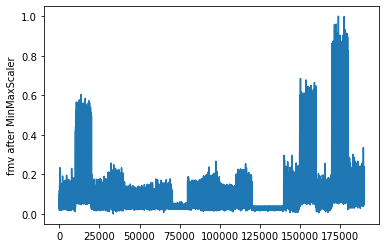

In [4]:
# the distribution of fmv
plt.plot(df['fmv'])
plt.ylabel('fmv after MinMaxScaler')

In [5]:
# select the representative policy by r code
data = pd.read_csv(r'./dat_340_Hkmeans.csv')
Hkmean_ID = data['recordID']
dat_Hkmean_340_Train = df.loc[df['recordID'].isin(Hkmean_ID)] 
dat_Hkmean_340_Test = df.loc[-df['recordID'].isin(Hkmean_ID)] 
x_train = dat_Hkmean_340_Train.drop(columns =(['fmv','recordID']),axis = 1)
y_train = dat_Hkmean_340_Train['fmv']
x_test = dat_Hkmean_340_Test.drop(columns =(['fmv','recordID']),axis = 1)
y_test = dat_Hkmean_340_Test['fmv']

Text(0.5, 1.0, 'fmv-selected 340')

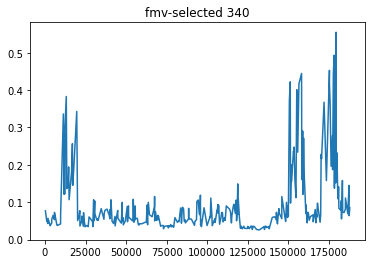

In [6]:
plt.plot(y_train)
plt.title('fmv-selected 340')

In [7]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4,1e-5])
        hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
        hp_act = hp.Choice('activation',values= ['gelu','relu','tanh'])
        model = keras.Sequential()
        for i in range(hp.Int('layers', 3, 9)):
            if i == 4 or i == 6:
                model.add(Dropout(0.2))
            model.add(tf.keras.layers.Dense(units=hp_units,
                                    activation=hp_act))

        model.add(tf.keras.layers.Dense(units = 1, activation = hp_act))
        model.compile(loss='mse',optimizer=keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                metrics=[ 'mse','mae']) #'mae',
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [1,16, 32]),
            **kwargs,
        )


In [8]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective="val_loss",
    max_trials=3,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

2022-12-08 10:02:32.813491: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 10:02:33.862058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2022-12-08 10:02:33.862642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [9]:
# tuner.search(x_train, y_train, epochs=200, validation_split=0.4)
# Get the optimal hyperparameters
tuner.search(x_train, y_train,epochs=50,  validation_split=0.3, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 3 Complete [00h 00m 01s]
val_loss: 0.036872465163469315

Best val_loss So Far: 0.014544765464961529
Total elapsed time: 00h 00m 12s
INFO:tensorflow:Oracle triggered exit


In [10]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.3)

Epoch 1/50
8/8 [==============================] - 1s 22ms/step - loss: 0.2423 - mse: 0.2423 - mae: 0.4316 - val_loss: 0.0647 - val_mse: 0.0647 - val_mae: 0.2127
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0554 - mse: 0.0554 - mae: 0.1898 - val_loss: 0.0262 - val_mse: 0.0262 - val_mae: 0.1093
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1664 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0964
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0443 - mse: 0.0443 - mae: 0.1723 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.0944
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0456 - mse: 0.0456 - mae: 0.1743 - val_loss: 0.0230 - val_mse: 0.0230 - val_mae: 0.0967
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0420 - mse: 0.0420 - mae: 0.1652 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.1250
Epoch 7/50
8/8 [==================

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 224)               7616      
                                                                 
 dense_10 (Dense)            (None, 224)               50400     
                                                                 
 dense_11 (Dense)            (None, 224)               50400     
                                                                 
 dense_12 (Dense)            (None, 224)               50400     
                                                                 
 dropout_2 (Dropout)         (None, 224)               0         
                                                                 
 dense_13 (Dense)            (None, 224)               50400     
                                                                 
 dense_14 (Dense)            (None, 224)              

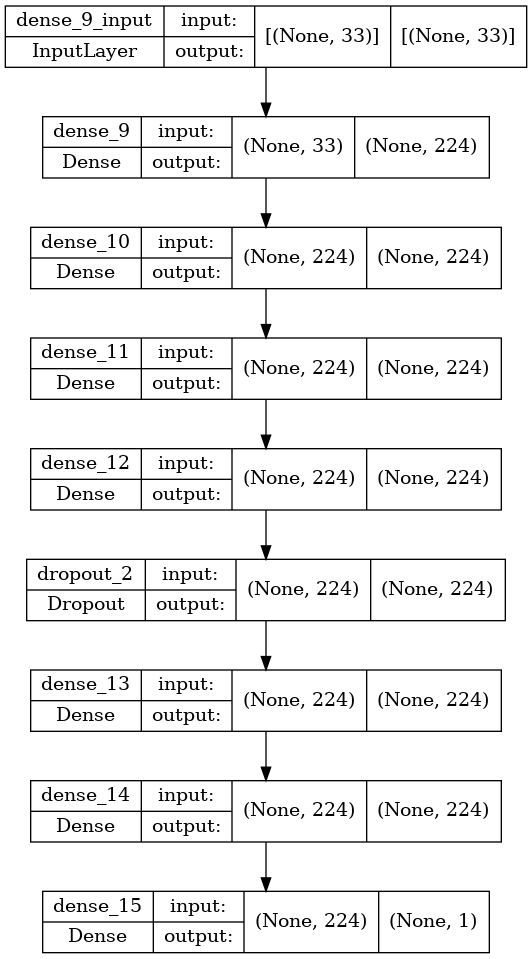

In [12]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)
# print("Validation accuracy:",*["%.8f"%(x) for x in history.history['val_mse']])

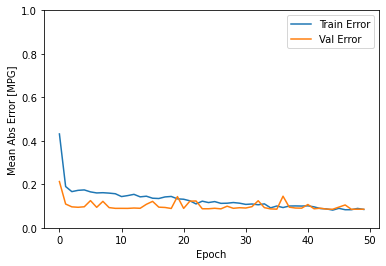

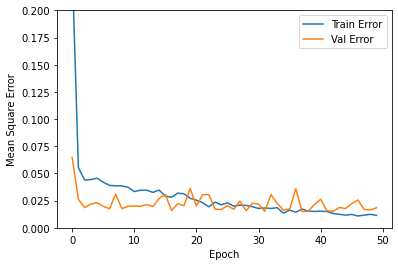

In [20]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0, 1])
    
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0, 0.2])
    plt.legend()
    # plt.title('Hidden_layers = 2')
    plt.show()


plot_history(history)

In [14]:
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

5927/5927 [==============================] - 19s 3ms/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0501
[test loss, test accuracy]: [0.007904764264822006, 0.007904764264822006, 0.05007470026612282]


In [26]:
y_pre = pd.read_csv(r'./y_pre.csv')
y_pre = y_pre.drop(columns =(['Unnamed: 0','boosted_340']),axis = 1)
y_pre.columns = [ 'recordID', 'okrig_340', 'ukrig_340', 'gb2_340','rokrig_340', 'fmv']
Measure(y_pre['fmv'],y_pre['ukrig_340'])

Mean squared error (MSE): 0.0007
Mean Absolute Error (MAE): 0.0173


In [27]:
Measure(y_pre['fmv'],y_pre['okrig_340'])

Mean squared error (MSE): 0.0006
Mean Absolute Error (MAE): 0.0137


In [28]:
Measure(y_pre['fmv'],y_pre['rokrig_340'])

Mean squared error (MSE): 0.0010
Mean Absolute Error (MAE): 0.0166


In [29]:
Measure(y_pre['fmv'],y_pre['gb2_340'])

Mean squared error (MSE): 0.0083
Mean Absolute Error (MAE): 0.0580


In [18]:
data = np.loadtxt('activation.txt')
plt.boxplot(data,notch=True)
plt.ylabel('Test mse')
plt.xticks([1,2,3],['tanh','gelu','relu'])
plt.show()

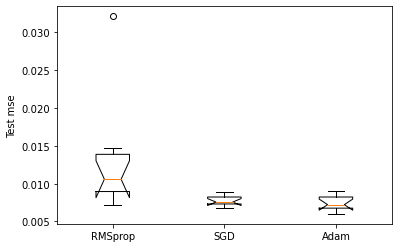

In [19]:
data = np.loadtxt('Results.txt')
plt.boxplot(data,notch=True)
plt.ylabel('Test mse')
plt.xticks([1,2,3],['RMSprop','SGD','Adam'])
plt.show()

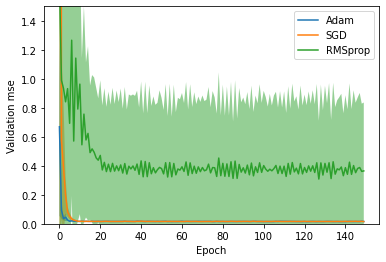

In [20]:
results1 =np.loadtxt('./4layers/p.txt')
results2 = np.loadtxt('./Adam/Adam_train.txt')
results3 = np.loadtxt('./RMSprop/RMSprop_train.txt')
plt.plot(np.arange(0,results1.shape[1]), np.mean(results1,0),label = 'Adam') 
plt.fill_between(np.arange(0,results1.shape[1]), np.mean(results1,0)-(1.96*np.std(results1,0)/np.sqrt(results1.shape[0])),np.mean(results1,0)+(1.96*np.std(results1,0)/np.sqrt(results1.shape[0])), alpha=0.5)  
plt.plot(np.arange(0,results2.shape[1]),np.mean(results2,0),label = 'SGD') 
plt.fill_between(np.arange(0,results2.shape[1]),                  np.mean(results2,0)-(1.96*np.std(results2,0)/np.sqrt(results2.shape[0])), np.mean(results2,0)+(1.96*np.std(results2,0)/np.sqrt(results2.shape[0])),alpha=0.5)  
plt.plot(np.arange(0,results3.shape[1]),np.mean(results3,0),label = 'RMSprop') 
plt.fill_between(np.arange(0,results3.shape[1]), np.mean(results3,0)-(1.96*np.std(results3,0)/np.sqrt(results3.shape[0])), np.mean(results3,0)+(1.96*np.std(results3,0)/np.sqrt(results3.shape[0])), alpha=0.5) 
plt.ylim([0,1.5]) 
plt.ylabel('Validation mse') 
plt.xlabel('Epoch') 
plt.legend() 
# plt.xticks(ticks=np.arange(0,results1.shape[1]), labels=np.arange(0,results1.shape[0]+1,100)) 
plt.show() 

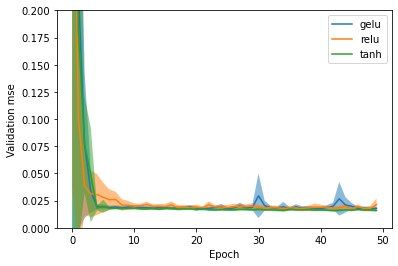

In [21]:
results1 =np.loadtxt('./gelu/gelu_train.txt')
results2 = np.loadtxt('./relu/relu_train.txt')
results3 = np.loadtxt('./tanh/tanh_train.txt')
plt.plot(np.arange(0,results1.shape[1]), np.mean(results1,0),label = 'gelu') 
plt.fill_between(np.arange(0,results1.shape[1]), np.mean(results1,0)-(1.96*np.std(results1,0)/np.sqrt(results1.shape[0])),np.mean(results1,0)+(1.96*np.std(results1,0)/np.sqrt(results1.shape[0])), alpha=0.5)  
plt.plot(np.arange(0,results2.shape[1]),np.mean(results2,0),label = 'relu') 
plt.fill_between(np.arange(0,results2.shape[1]),                  np.mean(results2,0)-(1.96*np.std(results2,0)/np.sqrt(results2.shape[0])), np.mean(results2,0)+(1.96*np.std(results2,0)/np.sqrt(results2.shape[0])),alpha=0.5)  
plt.plot(np.arange(0,results3.shape[1]),np.mean(results3,0),label = 'tanh') 
plt.fill_between(np.arange(0,results3.shape[1]), np.mean(results3,0)-(1.96*np.std(results3,0)/np.sqrt(results3.shape[0])), np.mean(results3,0)+(1.96*np.std(results3,0)/np.sqrt(results3.shape[0])), alpha=0.5) 
plt.ylim([0,0.2]) 
plt.ylabel('Validation mse') 
plt.xlabel('Epoch') 
plt.legend() 
# plt.xticks(ticks=np.arange(0,results1.shape[1]), labels=np.arange(0,results1.shape[0]+1,100)) 
plt.show() 